In [ ]:
import os
import numpy as np
from typing import Union
import cv2
import matplotlib.pyplot as plt
import glob as glob
import json
import pandas as pd
from PIL import Image
import keras

Using TensorFlow backend.


In [ ]:
from tensorflow.keras import Model, Sequential
from tensorflow.keras.utils import Sequence
from tensorflow.keras import activations
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import Input, SeparableConv2D,Concatenate,Conv2DTranspose, Add, UpSampling2D, Conv2D, GlobalAveragePooling2D, GlobalMaxPooling2D,MaxPooling2D, Dropout, BatchNormalization, Dense, Activation, MaxPool2D, AveragePooling2D
from tensorflow.keras.preprocessing.image import load_img


from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical 

from sklearn.metrics import confusion_matrix, classification_report
# from sklearn.model_selection import train_test_split
# from tensorflow.keras.layers.experimental.preprocessing import Resizing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.regularizers import l2
# from sklearn.utils import class_weight


In [ ]:
image_path = 'Montgomery/CXR_png'
mask_path = 'Montgomery/Masks'

In [ ]:
img_size = (512,512)
classes = ['lung']
num_classes = len(classes)
batch_size = 4

In [ ]:
segment_data_path = "segment_data"

In [ ]:
train_images = np.load(f'{segment_data_path}/train_images.npy').astype('float32')
train_masks = np.load(f'{segment_data_path}/train_masks.npy').astype('float32')
valid_images = np.load(f'{segment_data_path}/valid_images.npy').astype('float32')
valid_masks = np.load(f'{segment_data_path}/valid_masks.npy').astype('float32')
# valid_masks = np.expand_dims(valid_masks, axis = -1)
# train_masks = np.expand_dims(train_masks, axis = -1)
print(train_images.shape)
print(train_masks.shape)
print(valid_images.shape)
print(valid_masks.shape)

(110, 512, 512, 3)
(110, 512, 512)
(28, 512, 512, 3)
(28, 512, 512)


In [ ]:
#Class weight
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(
           'balanced',
            np.unique(np.ravel(train_masks).tolist()), 
            np.ravel(train_masks).tolist())
class_weights

array([0.67212478, 1.9524347 ])

In [ ]:
#One hot encoding
valid_masks = to_categorical(valid_masks, num_classes = 2)
train_masks = to_categorical(train_masks, num_classes = 2)

In [ ]:
#Loading model
from image_segmentation.keras_segmentation.models.unet import unet

model = unet(n_classes=2,  input_height=img_size[0], input_width=img_size[1])#, encoder_level = 2)

model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 514, 514, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 64) 1792        zero_padding2d[0][0]             
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 512, 512, 64) 256         conv2d[0][0]                     
_______________________________________________________________________________________

In [ ]:
#Set up, compile and train
checkpoint_folderpath = f'weights/{model.model_name}_unet'
if not os.path.exists(checkpoint_folderpath):
    os.makedirs(checkpoint_folderpath) 

checkpoint_filepath = checkpoint_folderpath + "/{epoch:02d}-{val_categorical_accuracy:.2f}.h5"
model_checkpoint_callback = ModelCheckpoint(
    filepath=f'{checkpoint_filepath}',
    save_weights_only=True,
    monitor='val_categorical_accuracy',
    mode='max',
    save_best_only=True)

keras_callbacks   = [
      EarlyStopping(monitor='val_categorical_accuracy', patience=20, mode='max', min_delta = 0.01),
      model_checkpoint_callback
]
#dice_coef_loss
# loss = weighted_categorical_crossentropy(class_weight)
opt = Adam(learning_rate=0.0001)
model.compile(
    optimizer=opt, loss='categorical_crossentropy', metrics=[dice_coef, 'categorical_accuracy'], loss_weights = class_weights,
    weighted_metrics=None, run_eagerly=None)
history = model.fit(
        x = train_images,
        y = train_masks,
        batch_size = batch_size,
        steps_per_epoch=(train_images.shape[0])//batch_size,
        epochs=50,
#         class_weight = class_weights,
    #     sample_weight=sample_weight,
        validation_data = (valid_images, valid_masks),
        validation_steps = (valid_images.shape[0])//batch_size,
        verbose = 1,
        callbacks = keras_callbacks,)


Epoch 1/50
27/27 [==============================] - 13s 486ms/step - loss: 0.4842 - dice_coef: 0.9192 - categorical_accuracy: 0.8651 - val_loss: 0.8893 - val_dice_coef: 0.8062 - val_categorical_accuracy: 0.5480
Epoch 2/50
27/27 [==============================] - 13s 470ms/step - loss: 0.1939 - dice_coef: 0.9755 - categorical_accuracy: 0.9666 - val_loss: 0.8021 - val_dice_coef: 0.8341 - val_categorical_accuracy: 0.7424
Epoch 3/50
27/27 [==============================] - 13s 464ms/step - loss: 0.1443 - dice_coef: 0.9827 - categorical_accuracy: 0.9741 - val_loss: 0.7653 - val_dice_coef: 0.8484 - val_categorical_accuracy: 0.7447
Epoch 4/50
27/27 [==============================] - 12s 461ms/step - loss: 0.1221 - dice_coef: 0.9857 - categorical_accuracy: 0.9775 - val_loss: 0.7777 - val_dice_coef: 0.8515 - val_categorical_accuracy: 0.7453
Epoch 5/50
27/27 [==============================] - 12s 462ms/step - loss: 0.1173 - dice_coef: 0.9858 - categorical_accuracy: 0.9775 - val_loss: 0.8152 - va

Epoch 37/50
27/27 [==============================] - 12s 444ms/step - loss: 0.0486 - dice_coef: 0.9930 - categorical_accuracy: 0.9874 - val_loss: 0.1050 - val_dice_coef: 0.9857 - val_categorical_accuracy: 0.9750
Epoch 38/50
27/27 [==============================] - 12s 443ms/step - loss: 0.0411 - dice_coef: 0.9941 - categorical_accuracy: 0.9893 - val_loss: 0.1055 - val_dice_coef: 0.9864 - val_categorical_accuracy: 0.9761
Epoch 39/50
27/27 [==============================] - 12s 444ms/step - loss: 0.0359 - dice_coef: 0.9949 - categorical_accuracy: 0.9908 - val_loss: 0.0871 - val_dice_coef: 0.9887 - val_categorical_accuracy: 0.9802
Epoch 40/50
27/27 [==============================] - 12s 444ms/step - loss: 0.0342 - dice_coef: 0.9951 - categorical_accuracy: 0.9912 - val_loss: 0.0740 - val_dice_coef: 0.9897 - val_categorical_accuracy: 0.9816
Epoch 41/50
27/27 [==============================] - 12s 443ms/step - loss: 0.0298 - dice_coef: 0.9958 - categorical_accuracy: 0.9923 - val_loss: 0.0733

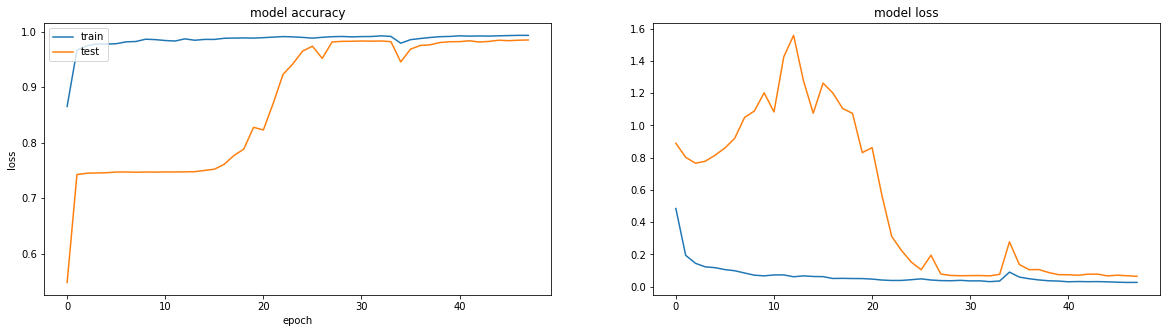

In [ ]:
# summarize history for accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20,5))
ax1.plot(history.history['categorical_accuracy'])
ax1.plot(history.history['val_categorical_accuracy'])
ax1.set_title('model accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'test'], loc='upper left')
# summarize history for loss
ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('model loss')
ax1.set_ylabel('loss')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
#Loading weights
weight_files = glob.glob(f'{checkpoint_folderpath}/*h5')
print(weight_files[-1])
model.load_weights(weight_files[-1])

#Wiping remaining weight files
for file in weight_files[:-1]:
    os.remove(file)

weights/unet_unet/48-0.98.h5


In [ ]:
#Ground truth
y_truth = np.ravel(np.argmax(valid_masks, axis = -1))
print(y_truth.shape)
print('True Valid',np.unique(y_truth, return_counts = True))

#Predict
# predict = model.predict_generator(test_generator,steps = nb_samples)
y_pred = []
for index in range(valid_images.shape[0]):
    y_pred.append(model.predict(valid_images[index:index+1, :,:,:]))
y_pred = np.vstack(y_pred)
y_pred = np.ravel(np.argmax(y_pred, axis = -1))
print(y_pred.shape)
print('Pred Valid', np.unique(y_pred, return_counts = True))


(7340032,)
True Valid (array([0, 1]), array([5484949, 1855083]))
(7340032,)
Pred Valid (array([0, 1]), array([5528200, 1811832]))


Classification Report
              precision    recall  f1-score   support

  background       0.99      0.99      0.99   5484949
        lung       0.98      0.96      0.97   1855083

    accuracy                           0.98   7340032
   macro avg       0.98      0.98      0.98   7340032
weighted avg       0.98      0.98      0.98   7340032

Confusion Matrix


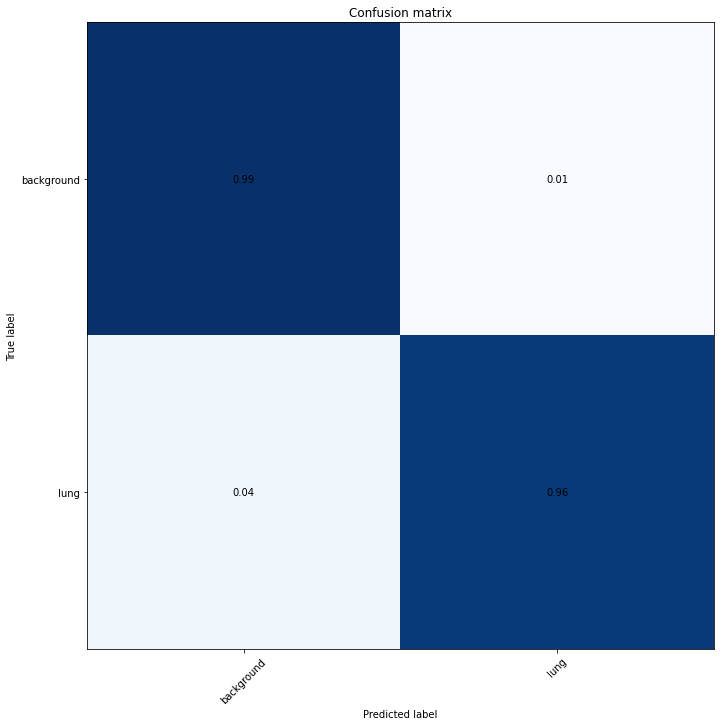

In [ ]:
#Evaluate
from evaluate import evaluate
classes = ['background', 'lung']
evaluate(y_truth, y_pred, classes)

Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_17 (ZeroPadding2 (None, 518, 518, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 256, 256, 64) 9472        zero_padding2d_17[0][0]          
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 256, 256, 64) 256         conv1[0][0]                      
_______________________________________________________________________________________

Epoch 1/50
27/27 [==============================] - 19s 713ms/step - loss: 0.2444 - dice_coef: 0.9635 - categorical_accuracy: 0.9432 - val_loss: 0.8534 - val_dice_coef: 0.8492 - val_categorical_accuracy: 0.7473
Epoch 2/50
27/27 [==============================] - 17s 613ms/step - loss: 0.0871 - dice_coef: 0.9914 - categorical_accuracy: 0.9872 - val_loss: 0.8136 - val_dice_coef: 0.8533 - val_categorical_accuracy: 0.7473
Epoch 3/50
27/27 [==============================] - 16s 601ms/step - loss: 0.0625 - dice_coef: 0.9938 - categorical_accuracy: 0.9898 - val_loss: 0.9525 - val_dice_coef: 0.8451 - val_categorical_accuracy: 0.7473
Epoch 4/50
27/27 [==============================] - 16s 604ms/step - loss: 0.0515 - dice_coef: 0.9950 - categorical_accuracy: 0.9916 - val_loss: 1.1478 - val_dice_coef: 0.8388 - val_categorical_accuracy: 0.7473
Epoch 5/50
27/27 [==============================] - 16s 603ms/step - loss: 0.0446 - dice_coef: 0.9956 - categorical_accuracy: 0.9926 - val_loss: 1.3095 - va

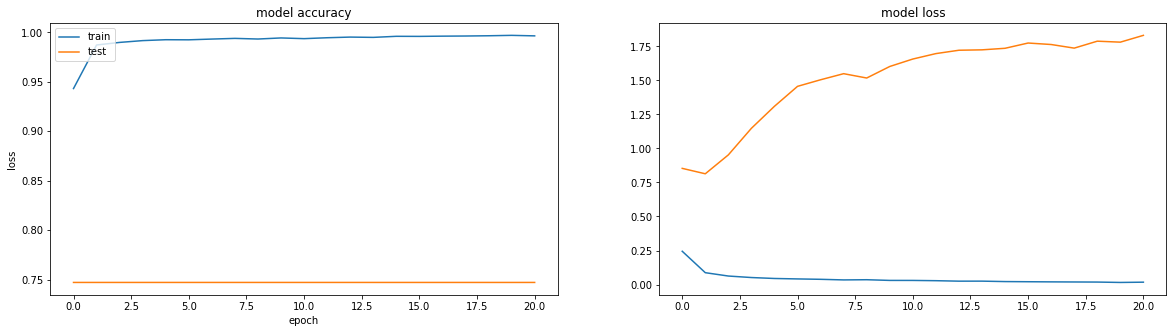

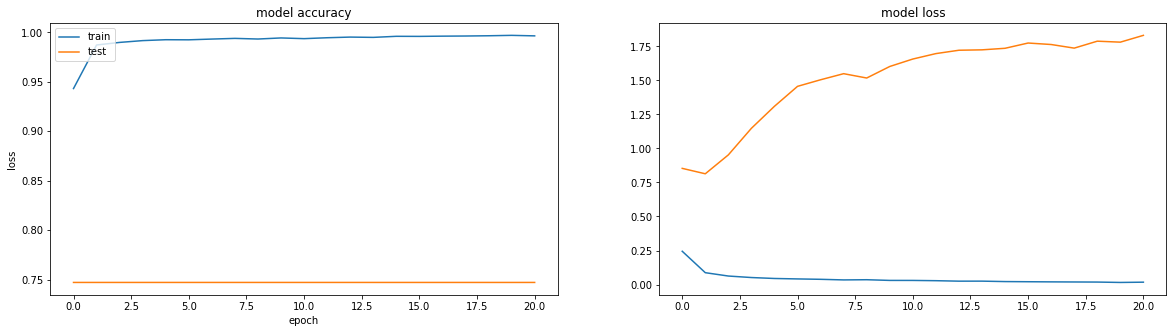

(7340032,)
True Valid (array([0, 1]), array([5484949, 1855083]))
(7340032,)
Pred Valid (array([0, 1]), array([7340015,      17]))
Classification Report
              precision    recall  f1-score   support

  background       0.75      1.00      0.86   5484949
        lung       0.00      0.00      0.00   1855083

    accuracy                           0.75   7340032
   macro avg       0.37      0.50      0.43   7340032
weighted avg       0.56      0.75      0.64   7340032

Confusion Matrix


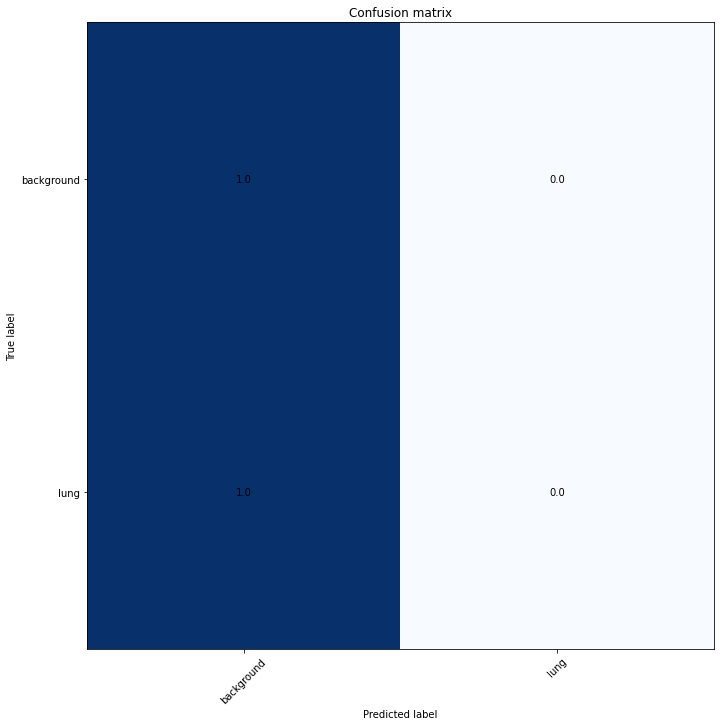

In [ ]:
# Set up for using Resnet50_Unet, with pretrained weights
from image_segmentation.keras_segmentation.models.unet import resnet50_unet

model = resnet50_unet(n_classes=2,  input_height=img_size[0], input_width=img_size[1])#, encoder_level = 2)

model.summary()

checkpoint_folderpath = f'weights/{model.model_name}_resnet50_unet'
if not os.path.exists(checkpoint_folderpath):
    os.makedirs(checkpoint_folderpath) 

checkpoint_filepath = checkpoint_folderpath + "/{epoch:02d}-{val_categorical_accuracy:.2f}.h5"
model_checkpoint_callback = ModelCheckpoint(
    filepath=f'{checkpoint_filepath}',
    save_weights_only=True,
    monitor='val_categorical_accuracy',
    mode='max',
    save_best_only=True)

keras_callbacks   = [
      EarlyStopping(monitor='val_categorical_accuracy', patience=20, mode='max', min_delta = 0.01),
      model_checkpoint_callback
]
#dice_coef_loss
# loss = weighted_categorical_crossentropy(class_weight)
opt = Adam(learning_rate=0.0001)
model.compile(
    optimizer=opt, loss='categorical_crossentropy', metrics=[dice_coef, 'categorical_accuracy'], loss_weights = class_weights,
    weighted_metrics=None, run_eagerly=None)
history = model.fit(
        x = train_images,
        y = train_masks,
        batch_size = batch_size,
        steps_per_epoch=(train_images.shape[0])//batch_size,
        epochs=50,
#         class_weight = class_weights,
    #     sample_weight=sample_weight,
        validation_data = (valid_images, valid_masks),
        validation_steps = (valid_images.shape[0])//batch_size,
        verbose = 1,
        callbacks = keras_callbacks,)


# summarize history for accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20,5))
ax1.plot(history.history['categorical_accuracy'])
ax1.plot(history.history['val_categorical_accuracy'])
ax1.set_title('model accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'test'], loc='upper left')
# summarize history for loss
ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('model loss')
ax1.set_ylabel('loss')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20,5))
ax1.plot(history.history['categorical_accuracy'])
ax1.plot(history.history['val_categorical_accuracy'])
ax1.set_title('model accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'test'], loc='upper left')
# summarize history for loss
ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('model loss')
ax1.set_ylabel('loss')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'test'], loc='upper left')
plt.show()

# from evaluate import evaluate
#Ground truth
y_truth = np.ravel(np.argmax(valid_masks, axis = -1))
print(y_truth.shape)
print('True Valid',np.unique(y_truth, return_counts = True))

#Predict
# predict = model.predict_generator(test_generator,steps = nb_samples)
y_pred = []
for index in range(valid_images.shape[0]):
    y_pred.append(model.predict(valid_images[index:index+1, :,:,:]))
y_pred = np.vstack(y_pred)
y_pred = np.ravel(np.argmax(y_pred, axis = -1))
print(y_pred.shape)
print('Pred Valid', np.unique(y_pred, return_counts = True))


#Evaluate
classes = ['background', 'lung']
evaluate(y_truth, y_pred, classes)